In [18]:
%matplotlib inline
from shapely.geometry import Point, Polygon
import geopandas as gpd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import rtree

In [2]:
mpl.__version__, pd.__version__, gpd.__version__

('1.5.1', '0.19.2', '0.2.1')

In [3]:
data_path = "../big_data_leave"

### loading the reduced version geojson of FEMA damage merged with HCAD property data

In [11]:
file = "/Harvey_FEMA_HCAD_Damage_reduced.geojson"
filePath = data_path+file
df_r = gpd.read_file(filePath)

In [12]:
print(type(df_r))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [13]:
df_r.head()

,ACCOUNT,ACREAGE,CONDO_FLAG,COUNTY,DMG_LEVEL,FIPS,HCAD_NUM,IMPROVEMEN,IN_DEPTH,KEY_MAP,...,TOTAL_BUIL,TOTAL_LAND,TOTAL_MARK,TOTAL_RCN_,UNITS,UNIT_PRICE,UNIT_TYPE,YR_IMPR,city,geometry
0,1202010030003,.2364,0,Fort Bend,AFF,48157,1202010030003,209721,0.189537,486T,...,2161,10298,251343,263198,7500.0000,5.35,SF,2000,KATY,POINT (-95.7323 29.7358)
1,1202010030004,.2001,0,Fort Bend,AFF,48157,1202010030004,232781,0.559052,486T,...,2707,8717,273557,292149,7500.0000,5.35,SF,2000,KATY,POINT (-95.732 29.7356)
2,0402830000004,1.1946,0,Liberty,MAJ,48291,0402830000004,269280,5.530396,381A,...,3114,52036,298000,363454,1.1946,23958.00,AC,2005,CROSBY,POINT (-94.99679999999999 29.9814)
3,1068480000011,.1931,0,Harris,MIN,48201,1068480000011,143489,2.645287,448F,...,2160,8410,168539,220753,7500.0000,3.30,SF,1976,HOUSTON,POINT (-95.63590000000001 29.8407)
4,1142710060011,.2011,0,Harris,AFF,48201,1142710060011,96345,0.772430,448E,...,1647,8760,120319,169027,6300.0000,3.50,SF,1979,HOUSTON,POINT (-95.6506 29.8344)


### Loading the watersheds shapefile

In [7]:
shapeFileWatersheds = "/HCFCD_TSARP_WATERSHEDS/"
filePathWatersheds = data_path+shapeFileWatersheds
df_ws = gpd.read_file(filePathWatersheds)

In [9]:
df_ws

,OBJECTID,OBJECTID_2,PERIMETER,Shape_Le_1,Shape_Leng,Shape_area,Shape_len,WTSHNAME,WTSHUNIT,cohgis_COU,geometry
0,1,1,348266.802,3.482668e+05,3.482668e+05,3.859573e+09,3.482668e+05,ADDICKS RESERVOIR,U,0.0,"POLYGON ((3022313.57235153 13908356.47545135, ..."
1,2,2,235815.935,2.358159e+05,2.358159e+05,8.679211e+08,2.358159e+05,CARPENTERS BAYOU,N,0.0,"POLYGON ((3179826.378388271 13904453.00064677,..."
2,3,3,611309.245,6.113092e+05,6.113092e+05,2.839400e+09,6.113092e+05,BUFFALO BAYOU,W,0.0,"POLYGON ((3053792.800731525 13881526.64525285,..."
3,4,4,331919.621,3.319196e+05,3.319196e+05,3.584947e+09,3.319196e+05,BARKER RESERVOIR,T,0.0,"POLYGON ((2934456.32844694 13890115.16416502, ..."
4,5,5,198017.248,1.980172e+05,1.980172e+05,8.635923e+08,1.980172e+05,HUNTING BAYOU,H,0.0,"POLYGON ((3130025.98389478 13872654.41955902, ..."
5,6,6,320030.019,3.200300e+05,3.200300e+05,2.607052e+09,3.200300e+05,SIMS BAYOU,C,0.0,"POLYGON ((3149981.468261942 13828352.76898926,..."
6,7,7,325539.577,3.255396e+05,3.255396e+05,3.096932e+09,3.255396e+05,WHITE OAK BAYOU,E,0.0,"POLYGON ((3049823.003224939 13909942.1051541, ..."
7,8,8,894930.741,8.949308e+05,8.949308e+05,7.448589e+09,8.949308e+05,CYPRESS CREEK,K,0.0,"POLYGON ((2933731.666182354 13966938.77921827,..."
8,9,9,838394.373,8.383944e+05,8.383944e+05,1.075747e+10,8.383944e+05,SPRING CREEK,J,0.0,"POLYGON ((2947383.288157284 14055527.23064993,..."
9,10,10,275255.398,2.752554e+05,2.752554e+05,1.549290e+09,2.752554e+05,WILLOW CREEK,M,0.0,"POLYGON ((3062458.039634615 13981104.85882568,..."


In [29]:
df_ws[geometry]

NameError: name 'geometry' is not defined

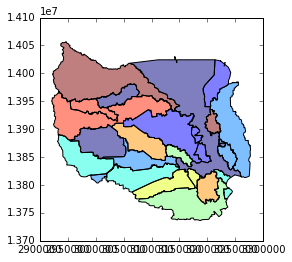

In [24]:
df_ws.plot()

In [10]:
type(df_ws)

geopandas.geodataframe.GeoDataFrame

In [21]:
df_ws.crs

{'datum': 'NAD83',
 'lat_0': 27.83333333333333,
 'lat_1': 28.38333333333333,
 'lat_2': 30.28333333333334,
 'lon_0': -99,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 600000,
 'y_0': 3999999.999999999}

In [30]:
df_ws = df_ws.to_crs({'init': 'epsg:4326'})

In [32]:
df_ws.crs

{'init': 'epsg:4326'}

In [31]:
df_r.crs

{'init': 'epsg:4326'}

### Merging the watershed geodataframe with the already merged HCAD property dataset & FEMA modeled damage dataset

In [33]:
properties_in_watershed = gpd.sjoin(df_r, df_ws, how="inner", op='intersects')
properties_in_watershed.head()

,ACCOUNT,ACREAGE,CONDO_FLAG,COUNTY,DMG_LEVEL,FIPS,HCAD_NUM,IMPROVEMEN,IN_DEPTH,KEY_MAP,...,OBJECTID,OBJECTID_2,PERIMETER,Shape_Le_1,Shape_Leng,Shape_area,Shape_len,WTSHNAME,WTSHUNIT,cohgis_COU
0,1202010030003,.2364,0,Fort Bend,AFF,48157,1202010030003,209721,0.189537,486T,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.62591,BARKER RESERVOIR,T,0.0
1,1202010030004,.2001,0,Fort Bend,AFF,48157,1202010030004,232781,0.559052,486T,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.62591,BARKER RESERVOIR,T,0.0
114,0220120000001,1.2186,0,Fort Bend,AFF,48157,0220120000001,0,1.050186,444Y,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.62591,BARKER RESERVOIR,T,0.0
150,1202010010026,1.1930,0,Fort Bend,AFF,48157,1202010010026,0,0.189056,486T,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.62591,BARKER RESERVOIR,T,0.0
751,0481040000013,.8235,0,Harris,AFF,48201,0481040000013,0,0.040237,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.62591,BARKER RESERVOIR,T,0.0


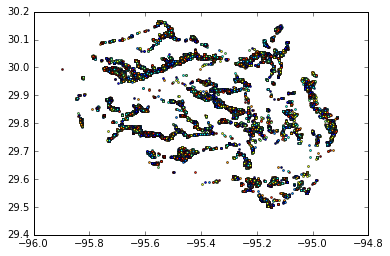

In [36]:
properties_in_watershed.plot()

In [40]:
type(properties_in_watershed)

geopandas.geodataframe.GeoDataFrame

In [45]:
properties_in_watershed

,ACCOUNT,ACREAGE,CONDO_FLAG,COUNTY,DMG_LEVEL,FIPS,HCAD_NUM,IMPROVEMEN,IN_DEPTH,KEY_MAP,...,OBJECTID,OBJECTID_2,PERIMETER,Shape_Le_1,Shape_Leng,Shape_area,Shape_len,WTSHNAME,WTSHUNIT,cohgis_COU
0,1202010030003,.2364,0,Fort Bend,AFF,48157,1202010030003,209721,0.189537,486T,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
1,1202010030004,.2001,0,Fort Bend,AFF,48157,1202010030004,232781,0.559052,486T,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
114,0220120000001,1.2186,0,Fort Bend,AFF,48157,0220120000001,0,1.050186,444Y,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
150,1202010010026,1.1930,0,Fort Bend,AFF,48157,1202010010026,0,0.189056,486T,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
751,0481040000013,.8235,0,Harris,AFF,48201,0481040000013,0,0.040237,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
837,1276480010001,.9160,0,Harris,AFF,48201,1276480010001,250538,0.077591,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
838,0481040000006,2.5000,0,Harris,AFF,48201,0481040000006,114098,1.494217,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
840,0481040000032,1.3209,0,Harris,AFF,48201,0481040000032,110946,0.333939,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
29455,0481040000042,2.3967,0,Harris,AFF,48201,0481040000042,220118,1.270294,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0
29599,0481040000039,1.6840,0,Harris,AFF,48201,0481040000039,216724,0.457596,444K,...,4,4,331919.621,331919.626248,331919.625019,3.584947e+09,331919.625910,BARKER RESERVOIR,T,0.0


In [46]:
properties_in_watershed.describe()

,FIPS,IN_DEPTH,LATITUDE,LONGITUDE,LocNum,index_right,OBJECTID,OBJECTID_2,PERIMETER,Shape_Le_1,Shape_Leng,Shape_area,Shape_len,cohgis_COU
count,68795.000000,68795.000000,68795.000000,68795.000000,68795.000000,68795.000000,68795.000000,68795.000000,6.879500e+04,6.879500e+04,6.879500e+04,6.879500e+04,6.879500e+04,68795.0
mean,48201.085733,2.661740,29.852503,-95.401137,8012.655542,10.600044,11.600044,11.600044,6.239653e+05,6.239653e+05,6.239653e+05,5.589496e+09,6.239653e+05,0.0
std,4.886993,3.097017,0.143058,0.206702,6521.743564,6.474089,6.474089,6.474089,2.704389e+05,2.704389e+05,2.704389e+05,3.003463e+09,2.704389e+05,0.0
min,48157.000000,0.000042,29.499700,-95.899600,0.000000,0.000000,1.000000,1.000000,1.042262e+05,1.042262e+05,1.042262e+05,4.260263e+08,1.042262e+05,0.0
25%,48201.000000,0.697641,29.763000,-95.576600,2415.000000,6.000000,7.000000,7.000000,3.982395e+05,3.982395e+05,3.982395e+05,3.585916e+09,3.982395e+05,0.0
50%,48201.000000,1.628868,29.850600,-95.415800,6414.000000,11.000000,12.000000,12.000000,5.899962e+05,5.899962e+05,5.899962e+05,5.600679e+09,5.899962e+05,0.0
75%,48201.000000,3.471525,29.986000,-95.242700,13003.000000,18.000000,19.000000,19.000000,8.949307e+05,8.949308e+05,8.949308e+05,7.448589e+09,8.949308e+05,0.0
max,48473.000000,33.565788,30.166100,-94.911600,32292.000000,21.000000,22.000000,22.000000,1.250538e+06,1.250538e+06,1.250538e+06,1.325635e+10,1.250538e+06,0.0


In [49]:
reduced_ws_out = data_path+"/Harvey_FEMA_HCAD_Damage_reduced_ws.geojson"

In [50]:
properties_in_watershed.to_file(reduced_ws_out, driver='GeoJSON')

In [55]:
ws_out = data_path+"/HarrisCounty_Watersheds_poly.geojson"

In [56]:
df_ws.to_file(ws_out, driver='GeoJSON')

Exception ignored in: <bound method Collection.__del__ of <open Collection '/Users/justingosses/Code/Harvey/six/Harvey_FEMA-HCAD_merged/big_data_leave/Harvey_FEMA_HCAD_Damage_reduced_watershed.geojson:OgrGeoJSON', mode 'w' at 0x22c8e5f98>>
Traceback (most recent call last):
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 416, in __del__
    self.__exit__(None, None, None)
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 411, in __exit__
    self.close()
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 395, in close
    self.flush()
  File "/Users/justingosses/anaconda/lib/python3.5/site-packages/fiona/collection.py", line 384, in flush
    if self.session is not None and self.session.get_length() > 0:
  File "fiona/ogrext.pyx", line 495, in fiona.ogrext.Session.get_length (fiona/ogrext.c:9385)
ValueError: Null layer


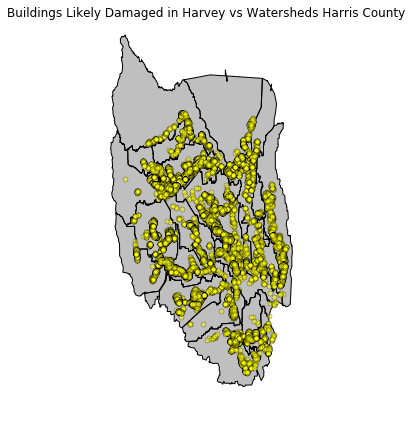

In [51]:
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = df_ws(ax=ax, color='gray')
properties_in_watershed.plot(ax=base, marker="o", mfc="yellow", markersize=5, markeredgecolor="black", alpha=0.5)
_ = ax.axis('off')
ax.set_title("Buildings Likely Damaged in Harvey vs Watersheds Harris County")

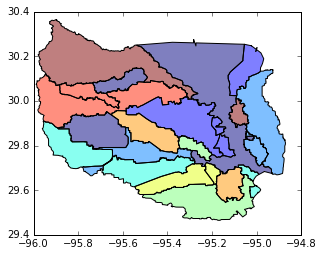

In [54]:
df_ws.plot()